In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from glob import glob

2025-02-22 23:04:08.526992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 23:04:08.541861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740240248.557995   33290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740240248.562876   33290 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 23:04:08.582335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  1
TensorFlow version:  2.18.0


### Build AlexNet from scratch

In [3]:
def AlexNet(input_shape=(227, 227, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Conv2D(256, (5, 5), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(384, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    model = Model(inputs=inputs, outputs=x, name="AlexNet")
    return model

alexnet = AlexNet()

feature_extractor = Model(inputs=alexnet.input, outputs=alexnet.output)

feature_extractor.summary()

I0000 00:00:1740240269.121943   33290 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,281,344 (222.33 MB)

 Trainable params: 58,281,344 (222.33 MB)

 Non-trainable params: 0 (0.00 B)

### Use AlexNet to extract features + apply augmentation

In [17]:
def augment_image(img):
    Augmentator = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # flip
    layers.RandomRotation(0.1), # rotate
    layers.RandomZoom(0.2),  # zoom
], name="Augmentator")
    augmented_img = Augmentator(img)
    img_after_augmentation = tf.squeeze(augmented_img) # augmented_img[0], remove batch
    return img_after_augmentation

In [19]:
import cv2
def extract_features(image_paths, model, target_size=(227, 227), is_aug=False):
    features = []
    labels = []

    for img_path, label in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        if is_aug:
            img = augment_image(img)
        img = img_to_array(img) / 255.0  
        img = np.expand_dims(img, axis=0)  
        
        feature = model.predict(img)  
        feature = feature.flatten() 
        
        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels)

In [20]:
train_dir = "../data/train"
val_dir = "../data/val"
test_dir = "../data/test"

def load_image_paths(folder, label):
    return [(img_path, label) for img_path in glob(os.path.join(folder, "*.jpg"))]

train_black = load_image_paths(os.path.join(train_dir, "black"), 1)
train_no_black = load_image_paths(os.path.join(train_dir, "no_black"), 0)
val_black = load_image_paths(os.path.join(val_dir, "black"), 1)
val_no_black = load_image_paths(os.path.join(val_dir, "no_black"), 0)
test_black = load_image_paths(os.path.join(test_dir, "black"), 1)
test_no_black = load_image_paths(os.path.join(test_dir, "no_black"), 0)

train_data = train_black + train_no_black
val_data = val_black + val_no_black
test_data = test_black + test_no_black

### Experiment 1: Augmentation

In [32]:
is_aug = True
X_train, y_train = extract_features(train_data, feature_extractor, is_aug=True)
X_val, y_val = extract_features(val_data, feature_extractor, is_aug=True)
X_test, y_test = extract_features(test_data, feature_extractor, is_aug=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

In [27]:
model = SVC()
model.fit(X_train, y_train)

SVC()

- val set

In [28]:
y_pred = model.predict(X_val)

Accuracy: 0.8833

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.90      0.87      0.88        30
   Black (1)       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



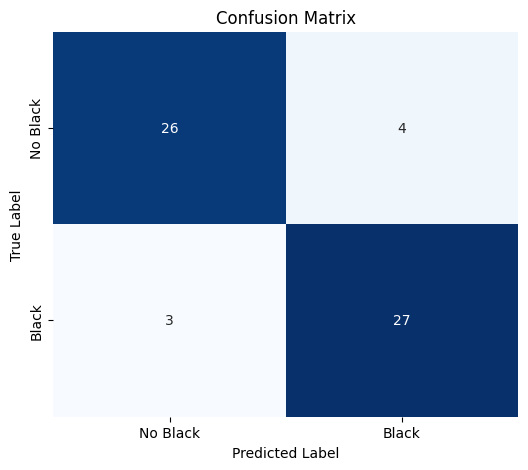

In [29]:
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

- test set

In [30]:
y_pred = model.predict(X_test)

Accuracy: 0.8833

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.90      0.87      0.88        30
   Black (1)       0.87      0.90      0.89        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



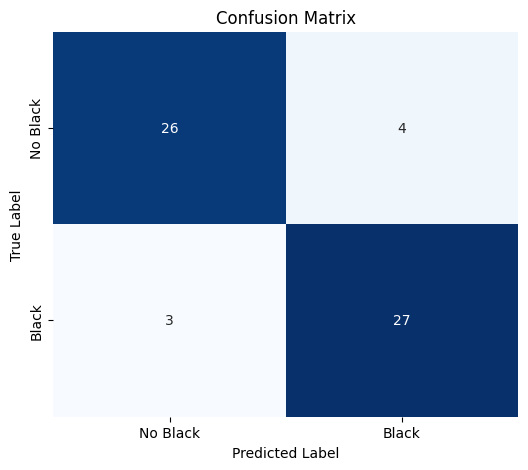

In [31]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## Experiment 2: Optimize model

In [36]:
param_grid = {
    "C": [0.1, 0.5, 1, 2, 10],
    "gamma": ["scale", "auto", 0.1, 1, 5],
    "kernel": ["linear", "rbf"]
}

In [37]:
from sklearn.model_selection import GridSearchCV
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Score: 0.9142857142857143


- try best params

In [38]:
model = SVC(C=10, gamma=1, kernel="rbf")
model.fit(X_train, y_train)

SVC(C=10, gamma=1)

- val set

In [39]:
y_pred = model.predict(X_val)

Accuracy: 0.9000

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.90      0.90      0.90        30
   Black (1)       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



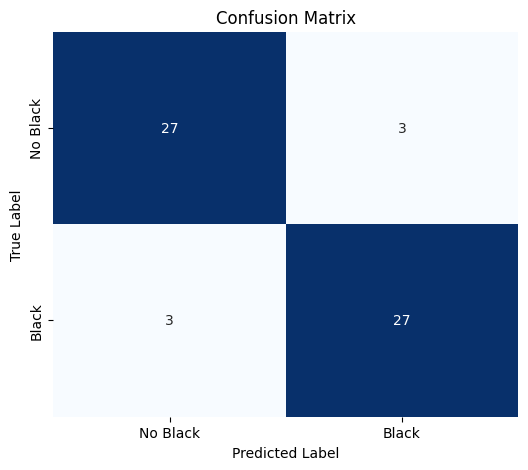

In [40]:
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

- test set

In [41]:
y_pred = model.predict(X_test)

Accuracy: 0.9500

Classification Report:
               precision    recall  f1-score   support

No Black (0)       0.94      0.97      0.95        30
   Black (1)       0.97      0.93      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



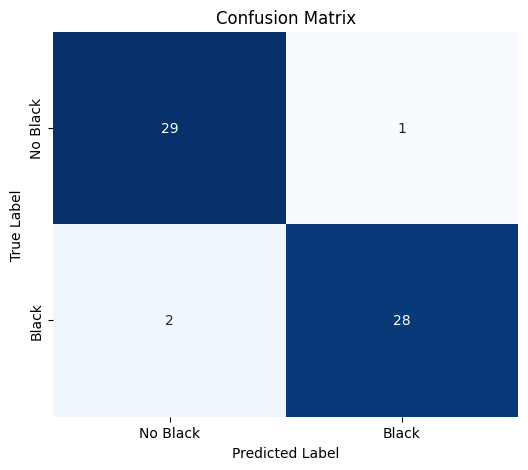

In [42]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["No Black (0)", "Black (1)"])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Black', 'Black'], yticklabels=['No Black', 'Black'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## Inference

In [ ]:
def wrapper_model(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (227, 227))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    
    feature, labels = extract_features([(None, None)], feature_extractor, is_aug=False)
    prediction = model.predict()
    
    return prediction.squeeze()

img_path = "../data/test/black/2_1_1_20170109190720964.jpg.chip.jpg"
result = wrapper_model(img_path)
plt.imshow(result, cmap="gray")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[0.02306159 0.         0.03665238 ... 0.         0.         0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.